In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import numpy as np
import itertools, os
from scipy.stats import pearsonr
from tqdm import tqdm

In [7]:
tss_df = pd.read_csv('../results/tss_positions.csv')

In [10]:
tss_df.drop_duplicates(subset=['Chromosome', 'Start', 'Strand']).shape

(51976, 5)

In [11]:
tss_df.shape

(53842, 5)

In [2]:
csv_dir = f'../results/summary_csvs/borzoi/'

In [12]:
cell_lines = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
track_index = [i for i, t in enumerate(target_df['description']) if
       ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                       'GM12878 ENCODE, biol_',
                                                       'PC-3'])]

cell_line_info = {}
for target_cell_line in cell_lines:
    cell_line_info[target_cell_line] = {}
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]
    
    
    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(track_index) == t).flatten()[0] for t in
                                                  targets]
    cell_line_info[target_cell_line]['target'] = '&'.join([str(t) for t in targets])

In [4]:
borzoi_enf_merge

NameError: name 'borzoi_enf_merge' is not defined

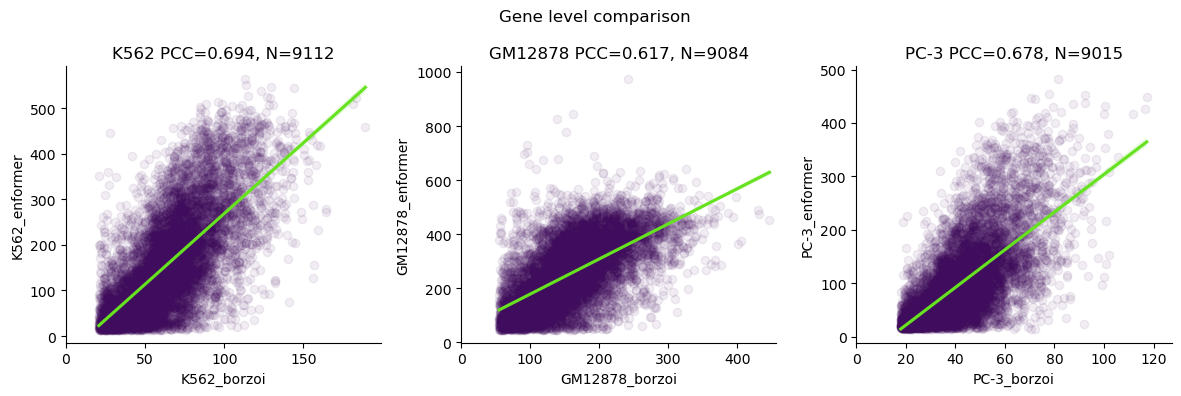

In [13]:
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
column_transl = {'K562 ENCODE, biol_': 'K562', 'GM12878 ENCODE, biol_': 'GM12878'}
for c, cell_line in enumerate(['K562', 'GM12878', 'PC-3']):
    ax = axes[c]
    borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{cell_line}*selected_genes.csv')[0])
    borzoi_selected_genes = borzoi_selected_genes.rename(columns=column_transl)
    enformer_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/enformer/*{cell_line}_selected_genes.csv')[0])
    borzoi_enf_merge = borzoi_selected_genes.merge(enformer_selected_genes, on=['gene_name'], suffixes=['_borzoi', '_enformer'])



    
    x=borzoi_enf_merge[f'{cell_line}_borzoi']
    y=borzoi_enf_merge[f'{cell_line}_enformer']
    sns.regplot(x=x, y=y, ax=ax, 
                scatter_kws = {"color": '#400c5d', "edgecolor": None, "alpha": 0.07},
                line_kws = {'color': "#66e221"})  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    _, xmax = ax.get_xlim()
    ax.set_xlim(0, xmax+10)
    ax.set_title(f'{cell_line} PCC={np.round(pearsonr(x,y)[0], 3)}, N={borzoi_enf_merge.shape[0]}')
plt.suptitle('Gene level comparison')
plt.tight_layout()


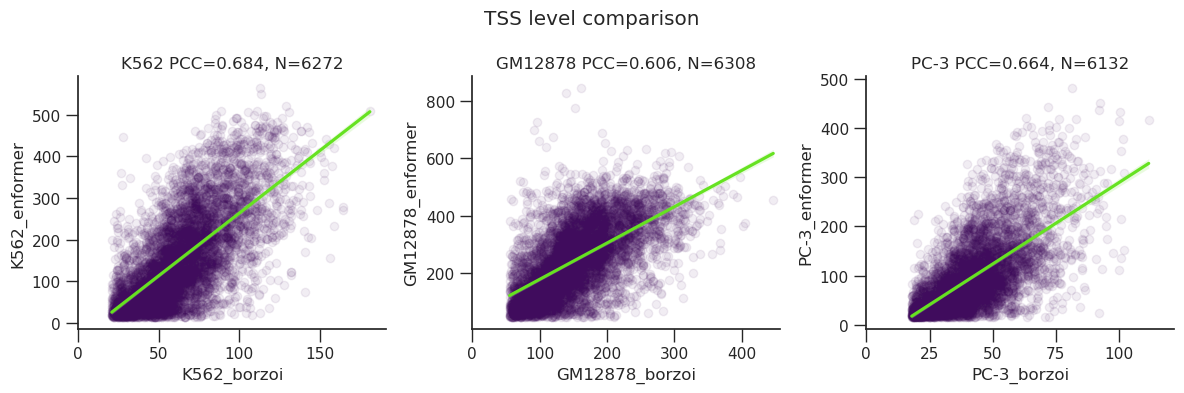

In [89]:
fig, axes = plt.subplots(1, 3, figsize=[12, 4])
column_transl = {'K562 ENCODE, biol_': 'K562', 'GM12878 ENCODE, biol_': 'GM12878'}
for c, cell_line in enumerate(['K562', 'GM12878', 'PC-3']):
    ax = axes[c]
    borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{cell_line}*selected_genes.csv')[0])
    borzoi_selected_genes = borzoi_selected_genes.rename(columns=column_transl)
    enformer_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/enformer/*{cell_line}_selected_genes.csv')[0])
    borzoi_enf_merge = borzoi_selected_genes.merge(enformer_selected_genes, on=['Chromosome', 'Start'], suffixes=['_borzoi', '_enformer'])
    
    x=borzoi_enf_merge[f'{cell_line}_borzoi']
    y=borzoi_enf_merge[f'{cell_line}_enformer']
    sns.regplot(x=x, y=y, ax=ax, 
                scatter_kws = {"color": '#400c5d', "edgecolor": None, "alpha": 0.07},
                line_kws = {'color': "#66e221"})  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    _, xmax = ax.get_xlim()
    ax.set_xlim(0, xmax+10)
    ax.set_title(f'{cell_line} PCC={np.round(pearsonr(x,y)[0], 3)}, N={borzoi_enf_merge.shape[0]}')
plt.suptitle('TSS level comparison')

plt.tight_layout()

In [14]:
model_name = 'borzoi'
threshold_enh, threshold_neu, threshold_sil = 0.9, 0.05, -0.2

res = []
for i, c in enumerate(cell_lines):
    
    # selected_tss_path = glob.glob(f'../results/summary_csvs/enformer/*{c.split()[0]}*_selected_genes.csv')[0]
    # cell_name = selected_tss_path.split('_')[-3]
    deltas = []
    wt_means = []
    seq_ids = []
    # print(cell_name)
    selected_tss = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{c}*selected_genes.csv')[0])

    
    # selected_tss = pd.read_csv(selected_tss_path)
    # borzoi_selected_genes = pd.read_csv(glob.glob(f'../results/summary_csvs/borzoi/*_{c}*selected_genes.csv')[0])
    # selected_tss = selected_tss.merge(borzoi_selected_genes, on=['gene_name', 'Start'], suffixes=['', '_borzoi'])
    
    for _, row in selected_tss.iterrows():
        path = f'../results/context_dependence_test_5/{model_name}/{utils.get_summary(row)}.pickle'
        context_res = utils.read_pickle(path)
        tss_activity = utils.read_pickle(f'../results/gencode_tss_predictions//{model_name}/{utils.get_summary(row)}.pickle')

        wt = ((tss_activity.mean(axis=0).sum(axis=-2) / 2))[:, cell_line_info[c]['output']].sum(axis=-1)
        mut = ((context_res['mut'].mean(axis=0).sum(axis=-2) / 2))[:, cell_line_info[c]['output']].sum(axis=-1)
        delta_per_model = (wt - mut) / wt
        deltas.append(delta_per_model.mean())
        wt_means.append(wt.mean())
        seq_ids.append(path)
    
        
    df = pd.DataFrame([deltas, seq_ids]).T
    df.columns = ['delta_mean', 'path']
    df['wt'] = wt_means
    df['context'] = [v for v in pd.cut(df['delta_mean'], 
                                       [df['delta_mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta_mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell_line'] = c.split()[0]
    
    print(df.shape)
    res.append(df)

res = pd.concat(res)
    

(10000, 5)
(10000, 5)
(10000, 5)


In [18]:
selected_contexts = res[[True if c in ['enhancing', 'neutral', 'silencing'] else False for c in res['context']]]

In [19]:
selected_contexts.groupby(['cell_line', 'context']).count()

delta_mean  path   wt
cell_line context                         
GM12878   enhancing         113   113  113
          neutral            54    54   54
          silencing          12    12   12
K562      enhancing         204   204  204
          neutral            61    61   61
          silencing          17    17   17
PC-3      enhancing          71    71   71
          neutral            63    63   63
          silencing          13    13   13

In [20]:
for cell_line, df in selected_contexts.groupby('cell_line'):
    df.to_csv(f'../results/summary_csvs/borzoi/{cell_line}_selected_contexts.csv')

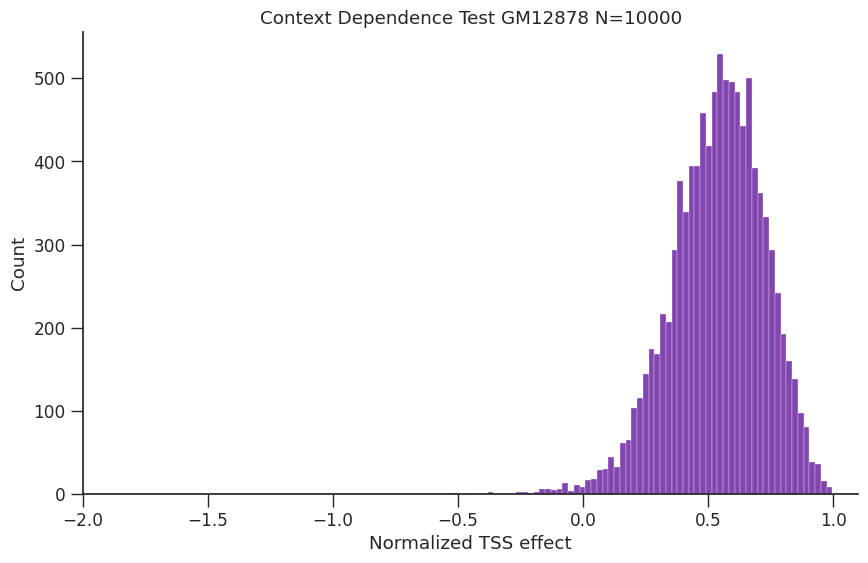

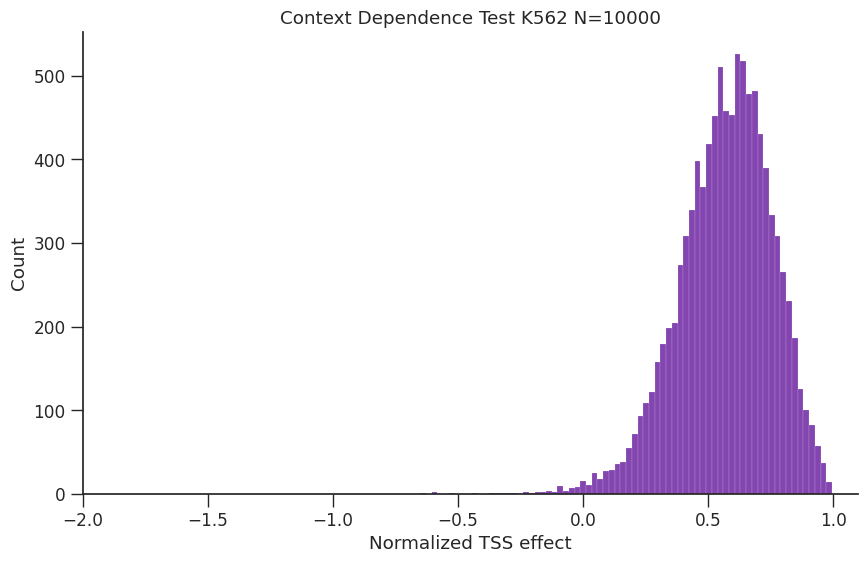

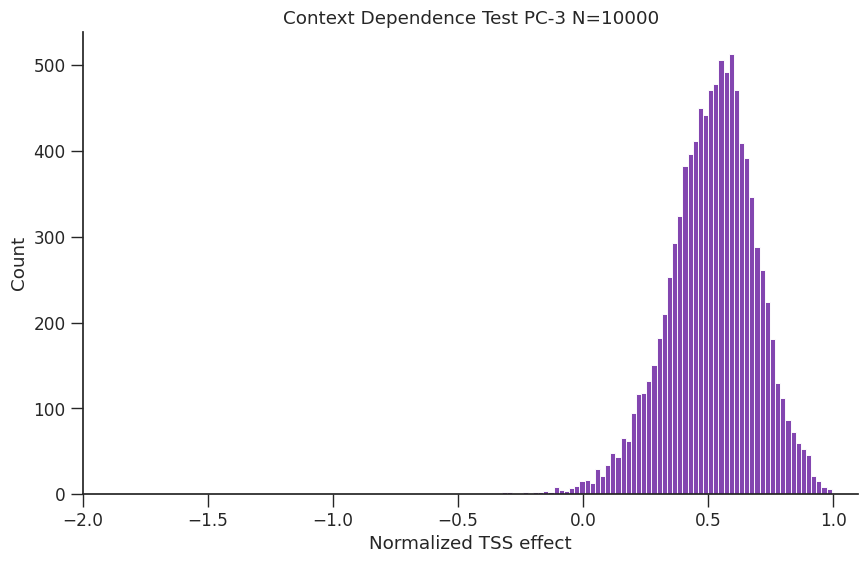

In [17]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell_line'):
    # df = df[(df['delta_mean'] > -10) & (df['wt'] > 3)]
    fig = plt.figure(figsize=[10, 6])
    ax = sns.histplot(x=df['delta_mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    plt.xlim([-2,1.1])
    # plt.xticks([-2, -1, 0, 1])
    # plt.yticks([100, 200, 300])
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


(113, 5)
(54, 5)
(12, 5)
['enhancing (N=113)', 'neutral (N=54)', 'silencing (N=12)']
(204, 5)
(61, 5)
(17, 5)
['enhancing (N=200)', 'neutral (N=61)', 'silencing (N=17)']
(71, 5)
(63, 5)
(13, 5)
['enhancing (N=71)', 'neutral (N=63)', 'silencing (N=13)']


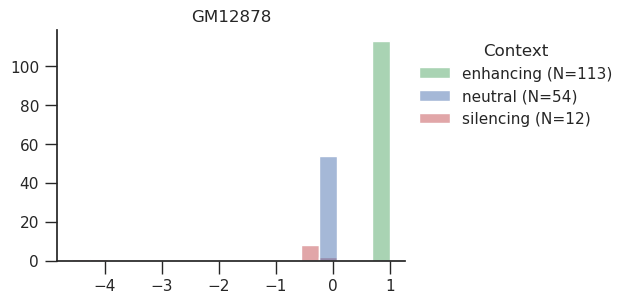

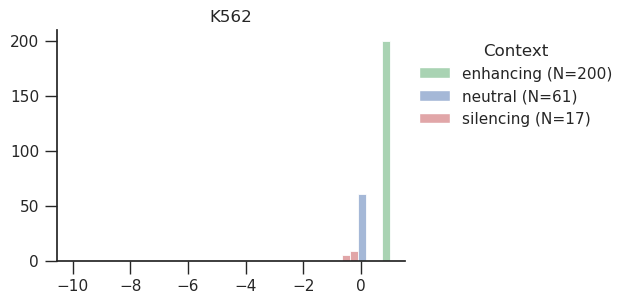

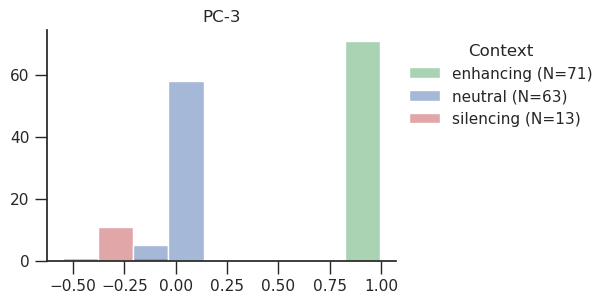

In [30]:
max_sample_size = 200
for k, df in res.groupby('cell_line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df_subsample = []
    for context_type, one_context_df in context_df.groupby('context'):
        print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)

    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta_mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    # fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    # context_df.to_csv(f'../results/summary_csvs//{model_name}/{k.split()[0]}_selected_contexts.csv')


In [31]:
summary_combined = res.reset_index(drop=True)
summary_combined.to_csv(f'{csv_dir}/context_dependence_test.csv') # summary of context effect for every selected gene


In [32]:

for k, df in summary_combined.groupby('cell_line'):  # per cell line
    context_df = df[(df['context'] != 'other') & (df['context'] != 'other1')]  # remove unclassified contexts
    context_df_subsample = []

    for context_type, one_context_df in context_df.groupby('context'):
        # subset if more than threshold number of rows
        if one_context_df.shape[0] > max_sample_size:
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)
    context_df.to_csv(f'{csv_dir}/{k}_selected_contexts.csv')

In [33]:
context_df

,delta_mean,path,wt,context,cell_line
20003,0.912598,../results/context_dependence_test_5/borzoi/CU...,17.937500,enhancing,PC-3
20073,0.915039,../results/context_dependence_test_5/borzoi/AN...,18.218750,enhancing,PC-3
20122,0.925293,../results/context_dependence_test_5/borzoi/KY...,18.437500,enhancing,PC-3
20434,0.976562,../results/context_dependence_test_5/borzoi/NU...,19.859375,enhancing,PC-3
20629,0.919434,../results/context_dependence_test_5/borzoi/CC...,20.734375,enhancing,PC-3
...,...,...,...,...,...
21617,-0.297852,../results/context_dependence_test_5/borzoi/ND...,25.390625,silencing,PC-3
21873,-0.244385,../results/context_dependence_test_5/borzoi/ZN...,26.437500,silencing,PC-3
22153,-0.342773,../results/context_dependence_test_5/borzoi/NB...,27.562500,silencing,PC-3
22174,-0.550781,../results/context_dependence_test_5/borzoi/NO...,27.687500,silencing,PC-3


In [22]:
utils.read_pickle('../results/sufficiency_test/borzoi/AMT_chr3_49422469_-.pickle')['mut'].shape

(102, 8, 6)